
for 33.000000 jobs the service node 1 statistics are:

  avg interarrivals .. = 218.1818182
  avg wait ........... = 47.6873646
  avg # in node ...... = 0.2185671
  avg delay .......... = 2.2717185
  avg # in queue ..... = 0.0104120
  avg service time.....= 45.4156461


the server statistics are:

    server     utilization     avg service        share

       1      0.2081550      45.4156461       1.0000000

for 35.000000 jobs the service node 2 statistics are:

  avg interarrivals .. = 205.7142857
  avg wait ........... = 135.9088909
  avg # in node ...... = 0.6693627
  avg delay .......... = 23.2247679
  avg # in queue ..... = 0.1143839
  avg service time.....= 112.6532595


the server statistics are:

    server     utilization     avg service        share

       1      0.5549788     114.1670670       1.0000000

for 30.000000 jobs the service node 3 statistics are:

  avg interarrivals .. = 240.0000000
  avg wait ........... = 605.7855744
  avg # in node ...... = 2.5873754
  avg 

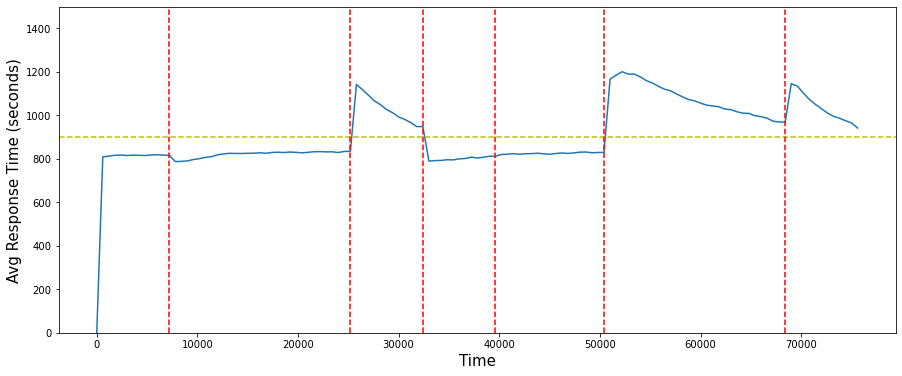

<Figure size 432x288 with 0 Axes>

INVALID CONFIGURATION
the average taking of a day at McDonald in Via Tuscolana is 12868.876721904699

the average loss percentage of a day at McDonald in Via Tuscolana is 4.264973042321775 %


the average utilization of the servers present in the nodes during the time slot 08:00 - 10:00 is:

  cash register         kitchen               table                delivery
     0.1670704            0.4358320             0.5527007           0.2367753


the average utilization of the servers present in the nodes during the time slot 10:00 - 15:00 is:

  cash register         kitchen               table                delivery
     0.3335475            0.5737991             0.8203443           0.3322802


the average utilization of the servers present in the nodes during the time slot 15:00 - 17:00 is:

  cash register         kitchen               table                delivery
     0.1773589            0.4900844             0.7727321           0.5152469


the average utilization of the servers 

In [1]:
from ipynb.fs.full.rngs import plantSeeds, selectStream, random
from ipynb.fs.full.rvms import cdfNormal,idfNormal, idfStudent
from colorama import Fore, Style, Back
from math import log,exp,fabs, sqrt
import statistics
from matplotlib import pyplot as plt
from welford import Welford
import numpy as np

###########################seed = 123456789
#seed = 365676778
#seed = 222222222
seed = 251119942

centers = [0,1,1,4,1]

k=[7200,7200,7200,7200]
timer=[0,7200,25200,32400, 39600, 50400, 68400]
time=[7200,25200,32400,39600,50400,68400]
NODES=4
TINY = 1.0e-10
SQRT2PI = 2.506628274631  # #/* sqrt(2 * pi) */

LAMBDA1LOW=0.004067
LAMBDA1MID=0.015373
LAMBDA1HIGH=0.073208

LAMBDA2LOW=0.000208
LAMBDA2MID=0.000667
LAMBDA2HIGH=0.008271

NUM1LOW=0.951185
NUM1MID=0.958450
NUM1HIGH=0.898474

NUM2LOW=0.048815
NUM2MID=0.041550
NUM2HIGH=0.101526


PRICE=10
BATCH=128
PHASES=7
MAXIMUM=10000000

CASS=1
KITCHEN=2
TABLE=3
DELIVERY=4

START =   0.0                    # initial (open the door)        */
STOP  =   75600.0                # secondi delle 21 ore del mcDonald */
SCREENSHOT=600
SLOT=126
arrivalTemp = [START for x in range(NODES+1)]


sumpar = [0.0 for x in range(NODES)]
difpar = [0.0 for x in range(NODES)]


num=[NUM1LOW, NUM2LOW, NUM1MID, NUM2MID, NUM1HIGH, NUM2HIGH]
b=0
ce=0
sem=0
cass=0
roh=[]
delivery=[]
deliv=0
aux=0
delivaux=0
flag=0
wf=[]
w=[]
ausilArray= []
uscita=0
memory=0
perduti=0
popolazione=0

class TypeNode:
    id= None
    ev= None
    servers=0.0
    index=None
    sum=0.0
    price=0
    number= 0.0
    partialsum=0.0 #variabile del nodo
    area=0.0
    flow=None
    lamb=0.0
    string= None
    last_service=0.0
    f=1
    active=0.0
    
    
    def __init__(self, id_node):
        self.id = id_node
        self.ev = Event()
        self.index = AccumSum()
        self.flow= Time()
        self.string = String()
        self.pretruncservice=[]
        self.posttruncservice=[]
        self.allpostservice=[]
        self.readytodelete=[]
        

class String:
    first= None
    second = None        

class Event:
    t = 0.0 #next event time
    x =None  #event status, 0 or 1
    last= 0.0
    dv=0

class Time:
    current = None          # current time                       */
    next = None             # next (most imminent) event time    */

class AccumSum:
    id= None                      # accumulated sums of                */
    service =0.0          #   service times                    */
    served = 0.0           #   number served                    */
    startserv = 0.0
    endserv = 0.0
    partialservice=0.0
    partialserved=0.0 #variabile del server
    postservice=0.0
    preservice=0.0
    
class Data:
    
    node=None
    event=None
    verify=0
          

for i in range(SLOT):
    wf.append(Welford())
    
for i in range(PHASES):
    w.append(Welford())

wp=Welford()

def Exponential(m):
# ---------------------------------------------------
# * generate an Exponential random variate, use m > 0.0 
# * ---------------------------------------------------
# */
  return (-m * log(1.0 - random()))


def Normal(m, s):
    # ========================================================================
    # Returns a normal (Gaussian) distributed real number.
    # NOTE: use s > 0.0
    #
    # Uses a very accurate approximation of the normal idf due to Odeh & Evans,
    # J. Applied Statistics, 1974, vol 23, pp 96-97.
    # ========================================================================
    #
    p0 = 0.322232431088
    q0 = 0.099348462606
    p1 = 1.0
    q1 = 0.588581570495
    p2 = 0.342242088547
    q2 = 0.531103462366
    p3 = 0.204231210245e-1
    q3 = 0.103537752850
    p4 = 0.453642210148e-4
    q4 = 0.385607006340e-2

    u = random()
    if (u < 0.5):
        t = sqrt(-2.0 * log(u))
    else:
        t = sqrt(-2.0 * log(1.0 - u))

    p = p0 + t * (p1 + t * (p2 + t * (p3 + t * p4)))
    q = q0 + t * (q1 + t * (q2 + t * (q3 + t * q4)))

    if (u < 0.5):
        z = (p / q) - t
    else:
        z = t - (p / q)

    return (m + s * z)



def TruncatedNormal(m, s, a, b):
    # ---------------------------------------------------
# * generate a Truncated Normal random variate, use m,s,a,b > 0.0,
# * ---------------------------------------------------
# */
    alpha = cdfNormal(m, s, a)
    beta = 1.0 - cdfNormal(m, s, b)
    u = Uniform(alpha, 1.0 - beta)
    return idfNormal(m, s, u)

def Uniform(a,b):  
# --------------------------------------------
# * generate a Uniform random variate, use a < b 
# * --------------------------------------------
# */
  return (a + (b - a) * random())  

def Slice(k):
    
    if k==7200:
        slc=7200
    if k==25200:
        slc=25200-7200
    if k== 32400:
        slc=32400-25200
    if k==39600:
        slc=39600-32400
    if k==50400:
        slc=50400-39600
    if k== 68400:
        slc=68400-50400
    if k==75600:
        slc=75600-68400
        
    return slc

#### parte di codice relativa i Print e Grafici

def PrintSystem(y):
    
    
    if  y < 7200 or 25200 <=  y < 32400 or 68400 <= y < STOP:
        num1=num[0]
        num2=num[1]
       
    
    elif 39600 <= y < 50400:
        num1=num[4]
        num2=num[5]  
        
        
    else:
        
        num1=num[2]
        num2=num[3] 
    
    final=(array[1]+array[2]+array[3])*num1 +(array[2]+array[4])*num2

    
def PrintStep(nodo,division,ran,i):
    
    print("\nfor {0:1f} jobs the service node".format( nodo.partialsum),i, "statistics are:\n")
    print("  avg interarrivals .. = {0:6.7f}".format(ran / nodo.partialsum))
    print("  avg wait ........... = {0:6.7f}".format( nodo.area /division))
    print("  avg # in node ...... = {0:6.7f}".format( nodo.area / ran))
    

def PrintStep2(nodo,division,ran,activeCenters,average):
    
    print("  avg delay .......... = {0:6.7f}".format(nodo.area /division))   
    print("  avg # in queue ..... = {0:6.7f}".format( nodo.area /ran))
    print("  avg service time.....= {0:6.7f}".format(average/activeCenters))
   
    print("\n\nthe server statistics are:\n")
    print("    server     utilization     avg service        share\n")

    
    for s in range(1, nodo.servers +1):
        if  nodo.index[s].partialservice /  ran >= 0.9:
                print(Fore.RED + "\n utilization asymptotic to 1")
                print(Fore.BLACK)
                if  nodo.index[s].partialservice / ran >= 1:
                    nodo.index[s].partialservice = ran
        if nodo.index[s].partialserved !=0:
            print("{0:8d} {1:14.7f} {2:15.7f} {3:15.7f}".format(s,  nodo.index[s].partialservice / ran,
                                                                 nodo.index[s].partialservice /  nodo.index[s].partialserved,
                                                                float( nodo.index[s].partialserved) / nodo.partialsum))
            
            
        else:  
            print("{0:8d}".format(s),"           0.0             0.0             0.0 ")
    
    
def switch_case(case):
    switcher = {
        0: "\n\nthe average utilization of the servers present in the nodes during the time slot 08:00 - 10:00 is:",
        1: "\n\nthe average utilization of the servers present in the nodes during the time slot 10:00 - 15:00 is:",
        2: "\n\nthe average utilization of the servers present in the nodes during the time slot 15:00 - 17:00 is:",
        3: "\n\nthe average utilization of the servers present in the nodes during the time slot 17:00 - 19:00 is:",
        4: "\n\nthe average utilization of the servers present in the nodes during the time slot 19:00 - 22:00 is:",
        5: "\n\nthe average utilization of the servers present in the nodes during the time slot 22:00 - 03:00 is:",
        6: "\n\nthe average utilization of the servers present in the nodes during the time slot 03:00 - 05:00 is:"
    }
    return switcher.get(case, "invalid case")


def plot_stats_global():

    
    x = [i*600 for i in range(SLOT+1)]
    y = [ausilArray[i] for i in range(SLOT+1)]
    plt.figure(figsize=(15,6))
    plt.plot(x,y)
    plt.ylabel(ylabel="Avg Response Time (seconds)", fontsize=15)
    plt.tick_params(labelsize=10)
    plt.xlabel(xlabel="Time", fontsize=15)
    plt.axhline(y=900, color='y', linestyle='--')
    for j in range(len(time)):
        plt.axvline(x=time[j], color='r', linestyle='--')
    plt.ylim(0, 1500)
    plt.figure()
    
    plt.show(block=False)
        


#### parte di codice relativa arrivi completamenti e gestione degli eventi   

def lambdaFunc(nodes,i):
    
    if  nodes[i].flow.current < 7200 or 25200 <=  nodes[i].flow.current < 32400 or 68400 <= nodes[i].flow.current < STOP:
        n1=LAMBDA1LOW
        n2=LAMBDA2LOW
    elif  39600 <=  nodes[i].flow.current < 50400:
        n1=LAMBDA1HIGH
        n2=LAMBDA2HIGH
    else:
        n1=LAMBDA1MID
        n2=LAMBDA2MID
    
    
    if i == CASS:
        nodes[i].lamb=n1
            
    elif i == KITCHEN:
        nodes[i].lamb=n2
        
        
        
def GetArrival(m, node):
# ----------------------------------------------------
# * generate the next arrival time, with rate variable
# * --------------------------------------------------
# */ 
    global arrivalTemp
    
    if node==1:
        selectStream(0)
        arrivalTemp[node] += Exponential(1/m)
        return (arrivalTemp[node])
    elif node==2:
        selectStream(1)
        arrivalTemp[node] += Exponential(1/m)
        return (arrivalTemp[node])


def newArrival(m,k,i):
    
    global arrivalTemp
   
    arrivalTemp[i]=k
    
    
    
    if k== 7200 or k==32400 or k== 50400:
        n1=LAMBDA1MID
        n2=LAMBDA2MID
    if k== 39600:
        n1=LAMBDA1HIGH
        n2=LAMBDA2HIGH
    if k==25200 or k== 68400 or k== 75600:
        n1=LAMBDA1LOW
        n2=LAMBDA2LOW
        
        
    if i == CASS:
        nodes[i].lamb=n1
            
    elif i == KITCHEN:
        nodes[i].lamb=n2
    
        
    if i==CASS:
        selectStream(0)
        arrivalTemp[i] += Exponential(1/m)
        
        return (arrivalTemp[i])
    elif i==KITCHEN:
        selectStream(1)
        arrivalTemp[i] += Exponential(1/m)
        return (arrivalTemp[i])
    
    
    
def GetService(i):
# --------------------------------------------
# * generate the next service time with rate 1/6
# * --------------------------------------------
# */ 
    if i == CASS:
        selectStream(2)
        return (TruncatedNormal(45,4,10,80))
    elif i == KITCHEN:
        selectStream(3)
        return (TruncatedNormal(112,5,60,164))
    elif i == TABLE:
        selectStream(4)
        return (TruncatedNormal(600,20,200,1600))
    elif i == DELIVERY:
        selectStream(5)
        return (TruncatedNormal(1200,40,800,2000))
        

def NextNode(nodes):
# -------------------------------------
# * return the index of the next node 
# * -----------------------------------
# */
    time_events=[]
    
    data=Data()
    
    for i in range (1, len(nodes)):
        for s in range(nodes[i].servers + 1):
            time_events.append(nodes[i].ev[s].t)
            
    time_events = sorted(time_events, key=lambda x: (x == 0.0, x))
    if time_events[0] ==MAXIMUM:
        data.verify=1
    
    
    for i in range(1, len(nodes)):
        for j in range(nodes[i].servers + 1):
            if time_events[0] == nodes[i].ev[j].t:
                data.node=i
                data.event=j
              
                return (data)
            
            
def FindOne(node):
# -----------------------------------------------------
# * return the index of the available server idle longest
# * -----------------------------------------------------
# */
    i = 1

    while (node.ev[i].x == 1):       # find the index of the first available */
        i += 1                        # (idle) server                         */
    #EndWhile
    s = i
    while (i < node.servers):         # now, check the others to find which   */ 
        i += 1                        # has been idle longest                 */
        if ((node.ev[i].x == 0) and (node.ev[i].last <= node.ev[s].last)):
            s = i
   #EndWhile 
    return (s)
            

#### parte di codice relativa income

def choosePrice(i):
    
       
    if i == CASS:
        nodes[i].price=0.005421
    
    if i == KITCHEN:
        nodes[i].price=0.0073655
        
    if i == TABLE:
        nodes[i].price=0.00062437
        
    if i == DELIVERY:
        nodes[i].price=0.0003411

def CalcolateIncome(cass):
    global ce
    expence=0
    for i in range(1,NODES+1):
            expence+=(nodes[i].flow.current-timer[ce])*nodes[i].servers*nodes[i].price
            
    ce+=1
    money=cass*PRICE+nodes[4].partialsum*PRICE -(expence)
    dailyIncome.append(money)

def incomePreparation(dailyMoney,dailyIncome,b):
    cass=nodes[1].partialsum        
    CalcolateIncome(cass)
    dailyMoney.append(0)
    for i in range(len(dailyIncome)):
        dailyMoney[b]+=dailyIncome[i]
        
    
############  parte di codice relativa al cambio fascia e tooning delle informazioni


def readyFunc(nodo):
    
    if len(nodo.readytodelete)!=0:
        for h in range(len(nodo.readytodelete)):
            nodo.area -=  nodo.readytodelete[h]
            if  nodo.area <0:
                nodo.area=0                
        nodo.readytodelete=[]
        
def postServiceFunc(nodo):
    
    if len(nodo.allpostservice)!=0:
        if k[i-1]!=STOP:
            for h in range(len(nodo.allpostservice)):
                nodo.readytodelete.append(nodo.allpostservice[h])
            
        else:
            for h in range(len(nodo.allpostservice)):
                nodo.area -=  nodo.allpostservice[h]
                if  nodo.area <0:
                    nodo.area=0   
        nodo.allpostservice=[]


def adjustService(nodo,average,activeCenters):
    
    if len(nodo.pretruncservice)!=0 or len(nodo.posttruncservice)!=0:
        
        for v in range(len(nodo.pretruncservice)):
            if nodo.pretruncservice[v][2] > nodo.servers:
                average +=nodo.pretruncservice[v][0]
                activeCenters+=1
            else:
                nodo.index[nodo.pretruncservice[v][2]].partialservice += nodo.pretruncservice[v][0]
                nodo.index[nodo.pretruncservice[v][2]].partialserved += 1
        for v in range(len(nodo.posttruncservice)):
            nodo.index[nodo.posttruncservice[v][2]%(len(nodo.index)-1)].partialservice += nodo.posttruncservice[v][0]
            nodo.index[nodo.posttruncservice[v][2]%(len(nodo.index)-1)].partialserved += 1    

def AreaUpdate(k,i, nodo):
    
    average=0
    io = 0
    ran=Slice(k[i-1])
    for s in range(1, nodo.servers +1):
        io+= nodo.index[s].served
   
    division=nodo.partialsum
    
    for u in range(len(nodo.posttruncservice)):
        division+=nodo.posttruncservice[u][1]
    
    
    
    PrintStep(nodo,division,ran,i)
    activeCenters=0  
    
    for s in range(1, nodo.servers+1):            # adjust area to calculate */ 
        nodo.area -=  nodo.index[s].partialservice   # averages for the queue   */
        if  nodo.area <0:
            nodo.area=0
            
    adjustService(nodo,average,activeCenters)
    
    
    for s in range(1, nodo.servers+1):             
        if nodo.index[s].partialserved !=0:
            activeCenters+=1
            average +=  (nodo.index[s].partialservice-nodes[i].index[s].preservice) /  nodo.index[s].partialserved
    
   
    TruncatedService(nodo)
    
    readyFunc(nodo)
    
    
    postServiceFunc(nodo)
        
    c=nodo.area /nodo.sum
    d=average/ nodo.servers                                                
    w=c+d
    array[i]=w
    
    PrintStep2(nodo,division,ran,activeCenters,average)
    
    cnt=0
    for s in range(1, nodo.servers +1): 
        if nodo.index[s].partialserved !=0:
            cnt=cnt+nodo.index[s].partialservice / ran
            
    
    
    return cnt/nodo.servers


def switchCenters(nodo, centro,i,k):
    
    list_drop=[]
    
    if nodo.servers <= centro:
        if nodes[i].partialsum !=0:
        
            res=AreaUpdate(k,i,nodes[i])
        else:
            res=0.0
        nodo.partialsum=0
        preServer=nodo.servers
        nodo.servers=centro
        for j in range(preServer, centro):
            nodo.ev.append(Event())
            nodo.ev[j+1].x=0
            nodo.index.append(AccumSum())
            nodo.index[j+1].startserv = k[i-1]
        l=nodo.number
        m=1
        while l>preServer:
                
            if m == nodo.servers-preServer+1:
                break
                      
            service   = GetService(i)
            nodo.index[preServer+m].service += service
            nodo.index[preServer+m].partialservice += service
            nodo.ev[preServer+m].t= k[i-1]+ service
            nodo.ev[preServer+m].x=1
            m=m+1
            l=l-1      
    
    else:
        w=nodo.servers-centro                     # se il server è spento e ci sono ancora servers 
                                                #da rimuovere aggiungo il suo indice alla lista drop
        y=0
        for s in range(1,nodo.servers+1):
            if y<w and nodo.ev[s].x ==0:
                list_drop.append(s)
                y=y+1
        
        if nodes[i].partialsum !=0:
            res=AreaUpdate(k,i,nodes[i])
        else:
            res=0.0
        nodo.partialsum=0
                                                            #cancella gli elementi nella list_drop salvandone ev ed index
                
        list_drop = sorted(list_drop, reverse= True)        
        for j in range(len(list_drop)):
            nodo.index[list_drop[j]].endserv = k[i-1]
            nodo.ev.pop(list_drop[j])
            nodo.index.pop(list_drop[j])
            nodo.servers=nodo.servers-1
            
        a=w-y                                        #se ci sono servers pieni ancora da rimuovere,il rimovo in ordine 
                                                     #con il t minore aggiornando l area della fase precedente
        nodes[i].active=a
    return res    
        
def TruncatedService(nodo):     # la funzione salva i servizi dei centri ancora attivi al cambio fascia 
                                             
    nodo.pretruncservice=[]
    for v in range(len(nodo.posttruncservice)):
        res=nodo.posttruncservice.pop(0)
        nodo.pretruncservice.append(res)
        
def ResetNode(nodo):
    
    for j in range(1,nodo.servers+1):
        nodo.index[j].partialservice=0
        nodo.index[j].partialserved=0
        if nodo.index[j].postservice!=0:
            nodo.index[j].partialservice=nodo.index[j].postservice
    nodo.area=0
    
def ControlSem(x):
    global sem
    if x == NODES:
       # PrintSystem()
        sem=0
        return sem
    else:
        return x

def ChangeSlice(centers, i):
    global sem, cass
    if sem==0:
        cass=nodes[2].partialsum
    sem =sem+1
    sumpar[i-1]=sumpar[i-1]+nodes[i].partialsum
    if sem == NODES:
        CalcolateIncome(cass)        
    res=switchCenters(nodes[i],centers[i],i,k)
    
    ResetNode(nodes[i])
               
    sem=ControlSem(sem)
    
    return res
    
    
    
def controlFunc(nodes, i):  # funzione di controllo per il cambio fascia
  
    global k,n, popolazione
    
    if  nodes[i].flow.current < 7200 or 25200 <=  nodes[i].flow.current < 32400 or 68400 <= nodes[i].flow.current < STOP:
        n1=LAMBDA1LOW
        n2=LAMBDA2LOW
    
        centers = [0,1,1,4,1]        
        
        if k[i-1]==25200:
            
            phaseroh=[0.0 for t in range(NODES)]
            
            popolazione+=nodes[2].partialsum
            
            for p in range(1,NODES+1):
                
                phaseroh[p-1]=ChangeSlice(centers, p)           
                k[p-1]=32400
               
            dailyroh.append(phaseroh)
            
        if k[i-1]==68400:
            
            phaseroh=[0.0 for t in range(NODES)]
            popolazione+=nodes[2].partialsum
            for p in range(1,NODES+1):
                
                phaseroh[p-1]=ChangeSlice(centers, p)
            
                k[p-1]=75600
           
            dailyroh.append(phaseroh)
                
        
            
    elif  39600 <=  nodes[i].flow.current < 50400:
            
        n1=LAMBDA1HIGH
        n2=LAMBDA2HIGH
        centers = [0,4,10,48,13]
        
        if k[i-1]==39600:
            
            phaseroh=[0.0 for t in range(NODES)]
            
            popolazione+=nodes[2].partialsum
            for p in range(1,NODES+1):
                phaseroh[p-1]=ChangeSlice(centers, p)
            
                k[p-1]=50400
                
            dailyroh.append(phaseroh)
        
        
    else:
        n1=LAMBDA1MID
        n2=LAMBDA2MID
        centers = [0,2,3,11,2]
        if k[i-1]== 7200:
            
            phaseroh=[0.0 for t in range(NODES)]
            popolazione+=nodes[2].partialsum
            for p in range(1,NODES+1):
                phaseroh[p-1]=ChangeSlice(centers, p)
                k[p-1]=25200
            
            dailyroh.append(phaseroh)
            
        if k[i-1]==32400:
            phaseroh=[0.0 for t in range(NODES)]
            popolazione+=nodes[2].partialsum
            for p in range(1,NODES+1):
                phaseroh[p-1]=ChangeSlice(centers, p)
            
                k[p-1]=39600
                
            dailyroh.append(phaseroh)
            
        if k[i-1]==50400:
            
            
            phaseroh=[0.0 for t in range(NODES)]
            
            popolazione+=nodes[2].partialsum
            for p in range(1,NODES+1):
                phaseroh[p-1]=ChangeSlice(centers, p)
                k[p-1]=68400
              
            dailyroh.append(phaseroh)

            

#### parte di codice relativa Grafici

def ScreenShotFunc(i):
    
    area_q=nodes[i].area
    
    delay_avg = 0.0            
    for s in range(1, nodes[i].servers+1):            # adjust area to calculate */ 
        area_q -=  nodes[i].index[s].partialservice   # averages for the queue   */
        if  area_q <0:
            area_q=0
    if nodes[i].partialsum != 0:
        delay_avg = area_q/ nodes[i].partialsum
        
    return delay_avg
            

def ScreenFill(nodo,i):
    if nodo.flow.current>= nodo.f*SCREENSHOT and len(screen[i-1])<126:
        shot= ScreenShotFunc(i)
        g=0
        while nodo.flow.current>= (nodo.f+1)*SCREENSHOT:
            nodo.f+=1
            g+=1 
        while g>0:
            screen[i-1].append(shot)
            g-=1         
        screen[i-1].append(shot)
        nodo.f+=1
    
            
#funzioni per il tempo di risposta totale                
def systemTime(screen,i,y):
    
    if  y < 7200 or 25200 <=  y < 32400 or 68400 <= y < STOP:
        num1=num[0]
        num2=num[1]
       
    
    elif 39600 <= y < 50400:
        num1=num[4]
        num2=num[5]  
        
        
    else:
        
        num1=num[2]
        num2=num[3] 
 
    avg_road=(screen[0][i]+screen[1][i]+screen[2][i]+
                   TruncatedNormal(45,4,10,80)+TruncatedNormal(112,5,60,164)+
                        TruncatedNormal(600,20,200,1600))*num1 +(screen[1][i]+screen[3][i]+
                                TruncatedNormal(112,5,60,164)+TruncatedNormal(1200,40,800,2000))*num2
    return avg_road
        
    
def fowardFunc(node):
    global flag
    global aux
    global delivaux
    
    if node==CASS:
        forwardNode(CASS,KITCHEN)
                                
    if node==KITCHEN:

        if delivaux==1:
                            
            forwardNode(KITCHEN,DELIVERY)

        else:
            forwardNode(KITCHEN,TABLE)

        if flag==1:
            nodes[node].ev[e].dv=1
            flag=0
                            
                            
    if node==TABLE or node==DELIVERY:
        nodes[0].number -= 1
                            
    aux=0
    delivaux=0
    
def forwardNode(startNode,forwardNode):
    global aux
    
    if aux!=0:
        nodes[forwardNode].flow.next    = aux
    else:
        nodes[forwardNode].flow.next    = nodes[startNode].ev[e].last
        if startNode == KITCHEN and forwardNode == DELIVERY:
                nodes[startNode].ev[e].dv=0
    nodes[forwardNode].area     += ( nodes[forwardNode].flow.next - nodes[forwardNode].flow.current) * nodes[forwardNode].number  # update integral  */
                             
    nodes[forwardNode].flow.current = nodes[forwardNode].flow.next
    nodes[forwardNode].number += 1
                           
    if (nodes[forwardNode].number <= nodes[forwardNode].servers):
        service  = GetService(forwardNode)
        s = FindOne(nodes[forwardNode])
                                    
        if nodes[forwardNode].flow.current + service> k[startNode-1] and k[startNode-1]!=STOP:
            nodes[forwardNode].index[s].postservice= nodes[forwardNode].flow.current + service - k[startNode-1]
            nodes[forwardNode].allpostservice.append(nodes[forwardNode].index[s].postservice)
            nodes[forwardNode].index[s].preservice= service - nodes[forwardNode].index[s].postservice
            nodes[forwardNode].posttruncservice.append([service,nodes[forwardNode].index[s].preservice/service,s])
            nodes[forwardNode].index[s].service += nodes[forwardNode].index[s].preservice
            nodes[forwardNode].index[s].partialservice += nodes[forwardNode].index[s].preservice
                                    
        else:

            nodes[forwardNode].index[s].service += service
            nodes[forwardNode].index[s].partialservice += service   

        nodes[forwardNode].ev[s].t      =  nodes[node].flow.current + service
        nodes[forwardNode].ev[s].x      = 1
    #EndIf
    
def exitFunc(node):
        exit=0                
        if nodes[node].number-nodes[node].servers>nodes[node].servers*0.5:
            #exit=0.1
            exit=0.5*(nodes[node].number-nodes[node].servers)/nodes[node].servers
            if exit>0.9:
                exit=0.9
                       
        if exit!=0:
            if random()< exit :
                nodes[node].number -= 1
                nodes[0].number -= 1
                return 1
            else:
                return 0
                    
        return 0    
############################Main Program###################################


global current_for_update
current_for_update=0
node=0
batch_index=0
flg=0
#num1=0.86733333
#num2=0.13286667
dailyIncome=[]
nodes = [TypeNode(i) for i in range(NODES+1)]
t = [0.0 for i in range(NODES+1)]
array = [0.0 for i in range(NODES+1)]
allEv=[[] for i in range(NODES) ]
allIndex=[[] for i in range(NODES) ]

job_list = []
dict_list = []
util= []
final_ro=[]
res=[]
delay=[]
wList=[]
stdList=[]
screen=[]
srt=[]
er=0
dailyMoney=[]
avg_resptime=[]
dailyroh=[]

p = [0.0 for i in range(NODES+1)]

plantSeeds(seed)

for i in range(NODES+1):
    nodes[i].servers=centers[i]


for i in range(BATCH):
    srt.append([])
    
    
for i in range(NODES +1):
    nodes[i].ev = [Event() for j in range(nodes[i].servers + 1)]
    nodes[i].index=[AccumSum() for j in range(nodes[i].servers + 1)]
    nodes[i].flow=Time()
    screen.append([])
    choosePrice(i)
        
nodes[0].ev[0].x=1

for i in range(1, NODES+1):
    nodes[i].flow.current = START
    lambdaFunc(nodes, i)
    if i==1 or i==2:
        nodes[i].ev[0].t   = GetArrival(nodes[i].lamb,i)
    nodes[i].ev[0].x   = 1


    
for i in range(1, NODES +1):
    for s in range(1,nodes[i].servers + 1):
        nodes[i].ev[s].t     = START          # this value is arbitrary because */
        nodes[i].ev[s].x     = 0              # all servers are initially idle  */
        nodes[i].index[s].service = 0.0
        nodes[i].index[s].served  = 0

    
while b < BATCH : 
   
    if b != 0:
        global ce
        ce=0
        er=0
        global k
        global sem
        global current_for_update
        global arrivalTemp
        
        k=[7200,7200,7200,7200,7200]
        sumpar = [0.0 for x in range(NODES)]
        difpar = [0.0 for x in range(NODES)]
        screen=[]
        sem=0
        cass=0
        current_for_update=0
        arrivalTemp = [START for x in range(NODES+1)]
        
        for i in range(NODES+1):
            nodes[i].servers=centers[i]

        for i in range(NODES +1):
            nodes[i].ev = [Event() for j in range(nodes[i].servers + 1)]
            nodes[i].index=[AccumSum() for j in range(nodes[i].servers + 1)]
            nodes[i].flow=Time()
            nodes[i].f=1
            screen.append([])
            choosePrice(i)

        for i in range(1, NODES+1):
            nodes[i].flow.current = START
            lambdaFunc(nodes, i)
            if i==1 or i==2:
                nodes[i].ev[0].t   = GetArrival(nodes[i].lamb,i)
            nodes[i].ev[0].x   = 1
                        
        for i in range(1, NODES +1):
            for s in range(1,nodes[i].servers + 1):
                nodes[i].ev[s].t     = START          # this value is arbitrary because */
                nodes[i].ev[s].x     = 0              # all servers are initially idle  */
                nodes[i].index[s].service = 0.0
                nodes[i].index[s].served  = 0
        
        dailyIncome=[]
        dailyroh=[]
        nodes[0].ev[0].x=1
 
    for r in range(NODES+1):
        nodes[r].partialsum=0.0
       
    
    while ((nodes[0].ev[0].x != 0) or (nodes[0].number != 0)):
              
        if nodes[0].number>er:
            er=nodes[0].number
            
        elem      = NextNode(nodes)                                      # next event index */
        
        node=elem.node
        e=elem.event
        
        
        if elem.verify==1:

            nodes[node].number-=1
            nodes[0].number-=1
        
        if nodes[node].ev[e].t > k[node-1] and k[node-1]!=STOP:
            
            for i in range(1,NODES+1):
                nodes[i].flow.next=k[i-1]
                if nodes[i].flow.current != MAXIMUM and nodes[i].flow.next !=MAXIMUM :
                    nodes[i].area += (nodes[i].flow.next - nodes[i].flow.current) * (nodes[i].number) 
                    nodes[i].flow.current = nodes[i].flow.next                               # advance the clock*/
            ScreenFill(nodes[node],node)  
            controlFunc(nodes, node)
            
            
        else:
            
            nodes[node].flow.next    = nodes[node].ev[e].t                                       # next event time  */ 


            if nodes[node].flow.current != MAXIMUM and nodes[node].flow.next !=MAXIMUM :
                nodes[node].area     += ( nodes[node].flow.next - nodes[node].flow.current) * (nodes[node].number) 
                nodes[node].flow.current = nodes[node].flow.next                                       # advance the clock*/
  
            ScreenFill(nodes[node],node)
    
    
            if nodes[1].ev[0].x==0 and nodes[2].ev[0].x==0:
                    for j in range(3,5):
                        if nodes[j].number==0:
                            nodes[j].ev[0].x=0                         ####POTENZIALMENTE PROBLEMATICO
                            
            if nodes[3].ev[0].x==0 and nodes[4].ev[0].x==0:
                nodes[0].ev[0].x    = 0
    

            if (e == 0):                                                               # process an arrival*/     

                lambdaFunc(nodes, node)
                nodes[node].number += 1
                nodes[0].number += 1
                nodes[node].ev[e].last= nodes[node].ev[0].t
                
                
                if node ==CASS:
                    uscita=exitFunc(node)
                    if uscita==1:
                        perduti+=1
                
                
                if node==CASS or node==KITCHEN:
                    nodes[node].ev[0].t        = GetArrival(nodes[node].lamb, node)
                    
                    if  nodes[node].ev[0].t > k[node-1] and k[node-1]!=STOP:              
                        nodes[node].ev[0].t = newArrival(nodes[node].lamb,k[node-1], node)                    
                    
                if (nodes[node].ev[0].t > STOP):
                    current_for_update=nodes[node].ev[0].t
                    nodes[node].ev[0].x    = 0
                    nodes[node].ev[0].t    =MAXIMUM
                    
                    
                if node ==2 and nodes[node].number > nodes[node].servers: 
                    delivery.append(nodes[node].number - nodes[node].servers)
        
        
                if (nodes[node].number <= nodes[node].servers and nodes[node].number !=0 and uscita==0 ):
                    service  = GetService(node)
                    s = FindOne(nodes[node])
                    if node==2:
                        nodes[node].ev[s].dv=1
                    if nodes[node].flow.current + service > k[node-1] and k[node-1]!=STOP:
                        
                        nodes[node].index[s].postservice= nodes[node].flow.current +service - k[node-1]
                        nodes[node].allpostservice.append(nodes[node].index[s].postservice)
                        nodes[node].index[s].preservice= service - nodes[node].index[s].postservice
                        nodes[node].posttruncservice.append([service,nodes[node].index[s].preservice/service,s])
                        nodes[node].index[s].service += nodes[node].index[s].preservice
                        nodes[node].index[s].partialservice += nodes[node].index[s].preservice
                    else:
                        nodes[node].index[s].service += service
                        nodes[node].index[s].partialservice += service

                    nodes[node].ev[s].t      =  nodes[node].flow.current + service
                    nodes[node].ev[s].x      = 1
                    #EndIf
                uscita=0
               #EndIf
            else:                                          # process a departure */

                    nodes[node].sum += 1                                     # from server s       */     
                    nodes[node].partialsum += 1
                    nodes[node].index[e].served += 1
                    nodes[node].index[e].partialserved += 1

                    nodes[node].number -= 1
                    nodes[node].ev[e].last= nodes[node].ev[e].t 
                    
                    if nodes[node].ev[e].dv==1:
                            delivaux=1
                    
                    if nodes[node].active>0:
                        nodes[node].index[e].endserv = nodes[node].ev[e].t
                        aux=nodes[node].ev[e].t
        
                        nodes[node].ev.pop(e)
                        nodes[node].index.pop(e)
                        nodes[node].active -=1
                        nodes[node].servers=nodes[node].servers-1
            
                    else:
                        nodes[node].ev[e].t= MAXIMUM
                        s = e                       
                        if (nodes[node].number >= nodes[node].servers): 
                            service   = GetService(node)
                            
                            if node ==KITCHEN and len(delivery)!=0:
                                for j in range(len(delivery)):
                                    delivery[j]=delivery[j]-1
                                if delivery[0]==0:
                                    delivery.pop(0)
                                    flag=1
                            if nodes[node].flow.current + service> k[node-1] and k[node-1]!=STOP:
                                nodes[node].index[s].postservice= nodes[node].flow.current + service - k[node-1]
                                nodes[node].allpostservice.append(nodes[node].index[s].postservice)
                                nodes[node].index[s].preservice= service - nodes[node].index[s].postservice
                                nodes[node].posttruncservice.append([service,nodes[node].index[s].preservice/service,s])
                                nodes[node].index[s].service += nodes[node].index[s].preservice
                                nodes[node].index[s].partialservice += nodes[node].index[s].preservice
                            else:
                                
                                nodes[node].index[s].service += service
                                nodes[node].index[s].partialservice += service
                            nodes[node].ev[s].t      =  nodes[node].flow.current + service
                        else:
                            nodes[node].ev[s].x      = 0
                                                   
                    fowardFunc(node)    

     #EndWhile
    print("processed the batch",b+1)
        
    incomePreparation(dailyMoney,dailyIncome,b)
    
    for i in range(len(screen)):
        if len(screen[i])<126:
            g=126-len(screen[i])
            for z in range(g):
                screen[i].append(0.0)
    count=0            
    for i in range(SLOT):
        for j in range(4):
            ausilArray.append(screen[j][i])
        if i==11 or i == 41 or i== 53 or i== 65 or i== 83 or i== 113:
            ausilArray.append(memory)
            memory=0
        else:
            ausilArray.append(systemTime(screen,i,i*SCREENSHOT))
        ausilArray.append(dailyMoney[b])
        
        wf[i].add(np.array(ausilArray))
        if i==10 or i == 40 or i== 52 or i== 64 or i== 82 or i== 112:
            memory=ausilArray[4]
        
        
        ausilArray= []
        count+=1

    k=[75600,75600,75600,75600,75600]
    phaseroh=[0.0 for t in range(NODES)]
    popolazione+=nodes[2].partialsum
    for i in range(1,NODES+1):
        if nodes[i].partialsum !=0:
            phaseroh[i-1]=AreaUpdate(k,i,nodes[i])
    
    dailyroh.append(phaseroh)

    for i in range(1,NODES+1):
        ResetNode(nodes[i])
        for j in range(1, nodes[i].servers+1):
            nodes[i].index[-1].endserv=STOP
            nodes[i].ev.pop()
            nodes[i].index.pop()
    
    roh.append(dailyroh)
    b+=1

    for i in range(PHASES):
        w[i].add(np.array(dailyroh[i]))
        
    perduti=perduti/(perduti+popolazione)
    
    wp.add(np.array(perduti))
    perduti=0
    popolazione=0
    
#EndWhile
# Global batch means

rohmean=[]
for i in range(PHASES):
    rohmean.append(w[i].mean)
    
ausilArray.append(0)
for i in range(SLOT):
    ausilArray.append((wf[i].mean[4]))


plot_stats_global()

for i in range(SLOT):
    if wf[i-1].mean[4]>=900:
        print("INVALID CONFIGURATION")
        break
        
print("the average taking of a day at McDonald in Via Tuscolana is", wf[SLOT-1].mean[5])              # avg_income)

print("\nthe average loss percentage of a day at McDonald in Via Tuscolana is", wp.mean*100, "%") 

for h in range(PHASES):
    print(switch_case(h))
    print("\n  cash register         kitchen               table                delivery")
    print("{0:14.7f}       {1:14.7f}        {2:14.7f}      {3:14.7f}".format(rohmean[h][0],
                                                            rohmean[h][1],rohmean[h][2],rohmean[h][3]))
LOC = 0.95
u = 1.0 - 0.5 * (1.0 - LOC)  # interval parameter
n=60
st = idfStudent(n - 1, u)  # critical value of t
    
############## FARE INTERALLI DI CONFIDENZA


In [1]:
11179.293713562372

11179.293713562372

In [ ]:
import numpy as np

# Genera una distribuzione normale con media (mean) e deviazione standard (std)
mean = 1200
std = 40
size = 1000
normal_distribution = np.random.normal(mean, std, size)

# Tronca la distribuzione mantenendo solo i valori nell'intervallo [-1, 1]
truncated_distribution = normal_distribution[(normal_distribution >= 800) & (normal_distribution <= 2000)]

# Calcola la media e la varianza della distribuzione troncata
new_mean = np.mean(truncated_distribution)
new_variance = np.var(truncated_distribution)

print("Nuova media:", new_mean)
print("Nuova varianza:", new_variance)